In [1]:
%pylab inline
style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


In [2]:
from neuron import h, gui

// CVODE не работает с оригинальными файлами из (Rothman and Manis 2003)

In [3]:
h.cvode_active(0)

0.0

# Using original RM03 model and interface to NEURON

In [3]:
total_capacitance = 12 # pF

soma_area = total_capacitance * 1e-6 / 1 # pF -> uF, 1 uF/cm^2
soma_diam = 1e4*sqrt(soma_area/pi) # cm->um

print 'Soma area: %02.2e cm^2, diameter: %02.2f um'%(soma_area,soma_diam)
# Isn't it a bit too large a diameter? -> No, it's OK


Soma area: 1.20e-05 cm^2, diameter: 19.54 um


In [4]:
currents = ['klt', 'kht', 'na', 'ka', 'ih', 'hcno', 'leak']

In [5]:
def ns_to_mhocm2(x):
    "Convert from nanosiemens to siemens/cm^2"
    return 1e-9*x/soma_area

In [6]:

ptypeII = {cond:ns_to_mhocm2(val) for cond, val in 
 [('gnabar',1000), ('gkhtbar',150), ('gkltbar', 200),
  ('gabar', 0),  ('ghbar', 20),   ('glk', 2), ]}

ptypeIc = {cond:ns_to_mhocm2(val) for cond, val in 
         [('gnabar', 1000), ('gkhtbar', 150), ('gkltbar', 0),
          ('gabar', 0), ('ghbar', 0.5), ('glk', 2)]}

ptypeIt = {cond:ns_to_mhocm2(val) for cond, val in 
         [('gnabar', 1000), ('gkhtbar', 80), ('gkltbar', 0),
          ('gabar', 65), ('ghbar', 0.5), ('glk', 2)]}

#typeII['glk'] = 0

ptypeIc['Vm0'] = -63.9
ptypeIt['Vm0'] = -64.2
ptypeII['Vm0'] = -63.6 # mV

ptypeIc['Rin'] = 473
ptypeIt['Rin'] = 453
ptypeII['Rin'] = 71    # MOhm
# in S/cm^2
ptypeII

{'Rin': 71,
 'Vm0': -63.6,
 'gabar': 0.0,
 'ghbar': 0.0016666666666666666,
 'gkhtbar': 0.0125,
 'gkltbar': 0.016666666666666666,
 'glk': 0.00016666666666666666,
 'gnabar': 0.08333333333333334}

In [7]:
bushy = h.Section(name='bushy') 
stellatec = h.Section(name='stellatec')
stellatet = h.Section(name='stellatet')

neurons = [(bushy, ptypeII), (stellatec, ptypeIc), (stellatet, ptypeIt)]

for np in neurons:
    n,p = np
    n.nseg = 1
    n.diam = soma_diam
    n.L = soma_diam
    n.Ra = 150
    n.cm = 1
    n.insert('mujpow')
    #h.setpointer(n.i_ih_mujpow, n.i_ih)
    for cur in currents:
        n.insert(cur)
    n.ek = -70
    n.ena = 50
    n.gbar_hcno = 0
    n.gnabar_na = p['gnabar']
    n.gkhtbar_kht = p['gkhtbar']
    n.gkltbar_klt = p['gkltbar']
    n.gkabar_ka = p['gabar']
    n.ghbar_ih = p['ghbar']
    n.g_leak = p['glk']
    


In [10]:
v_vecb = h.Vector()             # Membrane potential vector
v_vecsc = h.Vector()
v_vecst = h.Vector()
t_vec = h.Vector()             # Time stamp vector

v_vecb.record(bushy(0.5)._ref_v)
v_vecsc.record(stellatec(0.5)._ref_v)
v_vecst.record(stellatet(0.5)._ref_v)

t_vec.record(h._ref_t)


1.0

In [11]:
h.v_init = ptypeII['Vm0']

In [12]:
h.tstop = 2000

In [13]:
h.run()

0.0

(-70, -50)

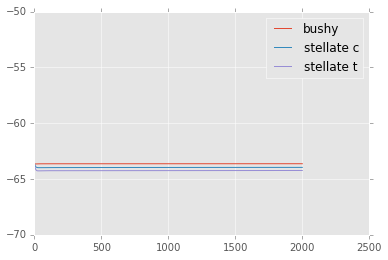

In [14]:
plot(t_vec, v_vecb, label='bushy');
plot(t_vec, v_vecsc, label='stellate c')
plot(t_vec, v_vecst, label='stellate t')
legend ()
ylim(-70,-50)

In [15]:
for n in neurons:
    print n[0].v

-63.6308382799
-63.9592460687
-64.2364613657


In [16]:
def split_ih(seg, gratio=5, eh=-43):
    "splits ih to Na and K components (crude)"
    v = seg.v
    gnah = seg.ih.i/(v*(gratio+1) - gratio*seg.ek - seg.ena)
    inah = gnah*(v-seg.ena)
    ikh = gratio*gnah*(v-seg.ek)
    return inah, ikh

In [17]:
def get_Rin(sec):
    seg = sec(0.5)
    gnar = seg.ina/(seg.v-seg.ena)  # Siemens/cm^2
    gkr = seg.ik/(seg.v-seg.ek)
    ghr = seg.i_ih/(seg.v- -43)
    glkr = seg.leak.i/(seg.v -seg.erev_leak)
    Ginx = (gnar + gkr + ghr + glkr)* seg.area()*1e-8
    return 1e-6/Ginx 

for n in neurons:
    print '{} Rin: {} | {} MOhm'.format(n[0].name(), get_Rin(n[0]), n[1]['Rin'])

bushy Rin: 71.0797445221 | 71 MOhm
stellatec Rin: 473.458416702 | 473 MOhm
stellatet Rin: 452.756938533 | 453 MOhm


In [20]:
bushy(0.5).erate_mujpow*bushy(0.5).area()


46152284.38485168

In [21]:
R = 8314.4  # Universal gaz constant, mJ / mole*K
F = 96485   # Faraday constant [C/mol]
F_ATP = 50 # kJ/mol

avogadro = 6.022e23 # N_a

In [22]:
def ratp_atwell(V, Rin, Ena = 50, Ek = -70):
    "returns resting ATP consumption rate in pmol ATP/s"
    # I take Rm in MOhms and V in mV
    # Thus, result is in nmole/sec
    out = (Ena-V)*(V-Ek)/(F*Rin*(V + 2*Ena - 3*Ek))
    return out*1e3 # nmol -> pmol

def pmol2molecules(x):
    return x*1e-12*avogadro

def atp2J(nATP):
    "Convert pmol ATP/s to energy usage in pJoule/s"
    return F_ATP * nATP * 1e3
    pas

def nJ2atp(nJ):
    "convert from nJoule/s to nmol ATP/s"
    return (nJ/F_ATP)*1e-3

## Оценка затрат в покое по Attwell и по Moujahid&D'Anjou

In [36]:
def mouj_Erate(seg, Iap=0, erev_ih = -43):
    v = seg.v
    acc = Iap*v
    acc += seg.ina*(v-seg.ena) 
    acc += seg.ik*(v-seg.ek)
    acc += seg.i_leak*(v-seg.erev_leak)
    acc += seg.ih.i*(v-erev_ih)
    factor = (1e-8) # um^2 -> cm^2
    factor *= (1e6) #-> pJ/s
    return acc*seg.area()*factor

def hasegawa_Erate(seg, Iap=0,erev_ih = -43):
    v = seg.v
    acc = Iap*v
    acc -= seg.ina*seg.ena 
    acc -= seg.ik*seg.ek
    acc -= seg.i_leak*seg.erev_leak
    acc -= seg.ih.i*erev_ih
    factor = (1e-8) # um^2 -> cm^2
    factor *= (1e6) #-> pJ/s
    return acc*seg.area()*factor

In [37]:
rATP_bushy  = ratp_atwell(bushy.v, Rin_t2x, Ek=-70)

print\
"""Оценка по Attwell: {:.3e} pmol ATP/сек
                 : {:.3e} pJ/s""".format(rATP_bushy, atp2J(rATP_bushy))

NameError: name 'Rin_t2x' is not defined

In [ ]:
dH_bushy2 = mouj_Erate(bushy(0.5))
dH_bushy3 = hasegawa_Erate(bushy(0.5))

rATP_bushy2 = nJ2atp(dH_bushy2)
rATP_bushy3 = nJ2atp(dH_bushy3)

In [ ]:
print\
"""Оценка по Moujahid & D'Anjou: {:.3e} pmole ATP/сек
                            : {:.3e} pJ/s""".format(rATP_bushy2, dH_bushy2)

In [ ]:
print\
"""Оценка по Hasegawa: {:.3e} pmole ATP/сек
                  : {:.3e} pJ/s""".format(rATP_bushy3, dH_bushy3)

Attwell to Moujahid ratio:

In [ ]:
rATP_bushy/rATP_bushy2

In [ ]:
inah, ikh = split_ih(seg)
print inah, ikh

jk = (bushy.ik + ikh)*soma_area/F # mmol/s
jna = (bushy.ina + inah)*soma_area/F

## В текущей модели, получается, что jk=jna, что сложно совместимо
## со стехиометрией Na,K-АТФ-азы

print allclose(jk,jna)

jatp_na = -jna/3
jatp_k = jk/2


print '%0.3e'%(jatp_na*1e9), 'pmol ATP/s [from jNa]'
print '%03e'%(jatp_k*1e9), 'pmol ATP/s [from jK]'

А это близко к тому, что дает оценка по  Attwell (хотя бы по порядку величин)...



**Можем ли мы найти такой ток, при котором iNa:iK = 3:2 в стационарном состоянии?** -> Это будет током ipump

In [40]:
istim = h.IClamp(bushy(0.5))

In [38]:
istim.delay = 0.01
istim.dur = 10000
amps = linspace(-1,1,10)
amps = concatenate([amps, linspace(-0.25,0.25,100)])
amps = sorted(amps)
cur_ratio = []
vrest = []
h.tstop = 2000
for amp in amps:
    istim.amp = amp
    h.run()
    inah,ikh = split_ih(seg)
    ina = (bushy.ina + inah)
    ik = (bushy.ik + ikh)
    vrest.append(seg.v)
    cur_ratio.append(ina/ik)

NameError: name 'istim' is not defined

NameError: name 'amps' is not defined

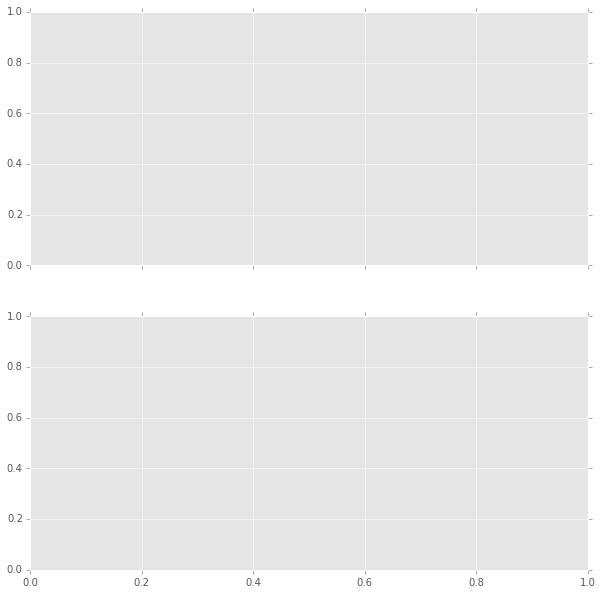

In [39]:
f, axs = subplots(2,1,sharex=True,figsize=(10,10))
axs[0].plot(amps, -array(cur_ratio))
setp(axs[0], ylim=(-5,5))
ylabel('iNa:iK')
axs[1].plot(amps, vrest)
axs[1].axhline(-70, color='m')
xlabel('I stim, nA')
xlim(-1,1)


In [35]:
Icut= amps[argmin((array(vrest)+70)**2)]
Icut

-0.12878787878787878

In [36]:
istim.delay = 0.01
istim.dur = 20000
#amps = linspace(-1,1,10)
amps = linspace(-0.04, -0.01, 100)
amps = sorted(amps)
cur_ratio = []
vrest = []
h.tstop = 10000
for amp in amps:
    istim.amp = amp
    h.run()
    inah,ikh = split_ih(seg)
    ina = (bushy.ina + inah)
    ik = (bushy.ik + ikh)
    vrest.append(seg.v)
    cur_ratio.append(ina/ik)

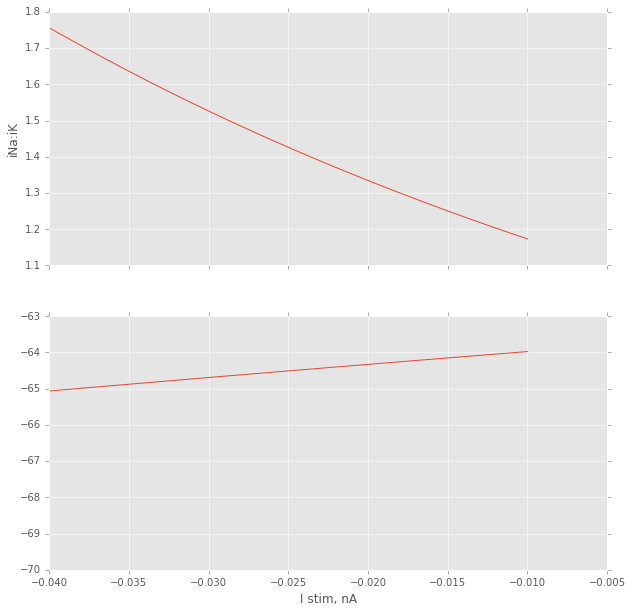

In [37]:
f, axs = subplots(2,1,sharex=True,figsize=(10,10))
axs[0].plot(amps, -array(cur_ratio))
setp(axs[0],  ylabel='iNa:iK')
axs[1].plot(amps, vrest)
axs[1].axhline(-70, color='m')
xlabel('I stim, nA')

Ipump получился -0.029 nA


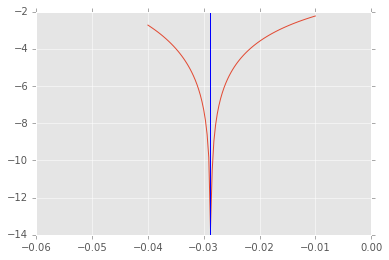

In [38]:
cr = -array(cur_ratio)
score = (cr-1.5)**2
plot(amps, log(score))
ip = amps[argmin(score)]
axvline(ip)
#ylim(-20,0)
xlim(-0.06, 0)

print 'Ipump получился %.3f nA'%ip

In [39]:
'New estimate: %.3e'%((-ip/F)*1e3), 'pmole ATP/s'

('New estimate: 2.984e-04', 'pmole ATP/s')

In [40]:
ip

-0.028787878787878789

In [41]:
istim.amp = ip
h.v_init=-60
h.tstop=10000
h.dt = 0.025


h.run()

0.0

In [42]:
print seg.v

inah, ikh = split_ih(seg)

print 'Current ratio:', -(inah + bushy.ina) / (ikh + bushy.ik)
print 'Sum current:', (inah + bushy.ina) + (ikh+bushy.ik)

-64.6630366783
Current ratio: 1.50313913037
Sum current: -0.0024551592356


In [43]:
ipumpx = -(inah + bushy.ina)*soma_area/(F*3)

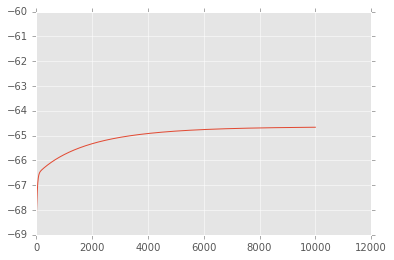

In [44]:
plot(t_vec, v_vec)

**Note** Только за эти времена токи уже устаканиваются, поэтому долго считать. Надо что ли алгебраически вывести...

In [45]:
dH_bushy2 = mouj_Erate(bushy(0.5),ip)
dH_bushy3 = hasegawa_Erate(bushy(0.5),ip)

rATP_bushy2 = nJ2atp(dH_bushy2)
rATP_bushy3 = nJ2atp(dH_bushy3)

In [46]:
print\
"""Оценка по Moujahid & D'Anjou: {:.3e} pmole ATP/сек
                            : {:.3e} pJ/s""".format(rATP_bushy2, dH_bushy2)

Оценка по Moujahid & D'Anjou: 4.834e-04 pmole ATP/сек
                            : 2.417e+01 pJ/s


In [47]:
print\
"""Оценка по Hasegawa: {:.3e} pmole ATP/сек
                  : {:.3e} pJ/s""".format(rATP_bushy3, dH_bushy3)

Оценка по Hasegawa: 4.462e-04 pmole ATP/сек
                  : 2.231e+01 pJ/s


In [48]:
print 'Новая оценка по Attwell-like: %.3e'%((ipumpx*1e9)), 'pmol ATP/s'

Новая оценка по Attwell-like: 3.041e-04 pmol ATP/s


Ну что же, теперь хотя бы порядок величин совпадает.

## Исправляем оценку по Муджахиду (23.03.2016)

Обнаружил недостаток в том, как мы оценивали затраты энергии по Moujahid: неявно предполагалось, что когда $V = E_h$, то $I_h$ не тратит энергию, но это не так: он одновременно использует $E_Na$ и $E_K$, потому что пропускает оба иона. Попробуем разложить этот ток на Na и К составляющие, и использовать их в подсчете энергозатрат по методу Moujahid.


In [26]:
istims = [h.IClamp(n[0](0.5)) for n in neurons]
h.run()

0.0

In [31]:
def mouj_Erate2(seg, Iap=0, erev_ih = -43):
    v = seg.v
    acc = Iap*v
    inah, ikh = split_ih(seg) # раскладываем Ih на компоненты
    ina = seg.ina + inah      # суммарный ток Na
    ik = seg.ik + ikh         # суммарный ток K
    acc += ina*(v-seg.ena) 
    acc += ik*(v-seg.ek)
    #acc += seg.i_leak*(v-seg.erev_leak) # Ну и утечка, хотя вклад от нее минимальный
    factor = (1e-8) # um^2 -> cm^2
    factor *= (1e6) #-> pJ/s
    return acc*seg.area()*factor

In [32]:
attw_rATP = [ratp_atwell(n[0].v,get_Rin(n[0])) for n in neurons]

mouj_dH = [mouj_Erate2(n[0](0.5)) for n in neurons]
mouj_rATP = map(nJ2atp, mouj_dH)

#dH_bushy2a = mouj_Erate2(bushy(0.5))
#dH_bushy3 = hasegawa_Erate(bushy(0.5),ip)

#rATP_bushy2a = nJ2atp(dH_bushy2a)
#rATP_bushy3 = nJ2atp(dH_bushy3)

In [33]:
def print_ratp_estimate(cell):
    attw = ratp_atwell(cell.v, get_Rin(cell))
    mouj_dh = mouj_Erate2(cell(0.5))
    mouj_atp = nJ2atp(mouj_dh)
    print "Attwell: %.3e pmol ATP/s"%attw
    print "Moujahid: %.3e pmol ATP/s"%mouj_atp
    print "A:M ratio: %2.3f"%(attw/mouj_atp)
    
def print_erate_estimate(cell):
    attw = ratp_atwell(cell.v, get_Rin(cell))
    seg = cell(0.5)
    mouj_dh = mouj_Erate2(seg)
    mujpow = seg.erate_mujpow*seg.area()*1e-8
    attw_erate = atp2J(attw)
    print "Attwell: %.3e pJ/s"%attw_erate
    print "Moujahid: %.3e pJ/s"%mouj_dh
    print "Mujpow dummy mech: %.3e pJ/s"%mujpow
    print "A:M ratio: %2.3f"%(attw_erate/mouj_dh)

In [36]:
seg = bushy(0.5)

In [42]:
ihna,ihk = split_ih(seg)

In [51]:
1e6*((seg.ina)*(seg.v-seg.ena) + (seg.ik)*(seg.v-seg.ek))

38460.236987376404

In [50]:
seg.erate_mujpow

38460.236987376404

In [34]:
for np in neurons:
    n = np[0]
    print '===== ', n.name(), ' ====='
    print_erate_estimate(n)
    #print "Mujpow dummy mechanism: ", n.
    print '------\n'


=====  bushy  =====
Attwell: 2.142e+01 pJ/s
Moujahid: 1.011e+01 pJ/s
Mujpow dummy mech: 4.615e-01 pJ/s
A:M ratio: 2.118
------

=====  stellatec  =====
Attwell: 3.062e+00 pJ/s
Moujahid: 3.275e-01 pJ/s
Mujpow dummy mech: 8.252e-02 pJ/s
A:M ratio: 9.351
------

=====  stellatet  =====
Attwell: 3.066e+00 pJ/s
Moujahid: 3.275e-01 pJ/s
Mujpow dummy mech: 7.916e-02 pJ/s
A:M ratio: 9.362
------



In [35]:
stellatec.ina, stellatec.ik, stellatec(0.5).ih.i, stellatec.i_leak

(-5.949951248315302e-05,
 1.586651897179199e-05,
 -0.00012983185923895653,
 0.00017345896411368025)

In [52]:
print\
"""Оценка по Moujahid & D'Anjou #2(a): {:.3e} pmole ATP/сек
                                  : {:.3e} pJ/s""".format(rATP_bushy2a, dH_bushy2a)

Оценка по Moujahid & D'Anjou #2(a): 1.872e-04 pmole ATP/сек
                                  : 9.358e+00 pJ/s


Мы получили меньше, чем в оценке по Attwell, но зато не добавляем искуственный "ток через Na/K насос", чтобы добиться нулевого суммарного потока Na и К через мембрану в модели предполагая, что любые discrepancies компенсируются потоками этих ионов, не рассматриваемых в модели напрямую.

In [53]:
istim.amp = ip
h.run()
dH_bushy2b = mouj_Erate2(bushy(0.5),ip)
rATP_bushy2b = nJ2atp(dH_bushy2b)

print\
"""Оценка по Moujahid & D'Anjou (2b): {:.3e} pmole ATP/сек
                                 : {:.3e} pJ/s""".format(rATP_bushy2b, dH_bushy2b)

Оценка по Moujahid & D'Anjou (2b): 6.549e-04 pmole ATP/сек
                                 : 3.274e+01 pJ/s


In [54]:
1e-6*0.03/soma_area

0.0024999999999999996

При добавлении и гиперполяризующего тока $\approx -0.03$ nA ($0.0025$ mA/cm^2) энаргозатраты выросли (с учетом тока) почти в 3.5 раза.

** Но что выбрать, оценку по Moujahid или Hasegawa, и есть ли разница?**

In [47]:
def hasegawa_Erate2(seg, Iap=0,erev_ih = -43):
    v = seg.v
    acc = Iap*v
    inah, ikh = split_ih(seg) # раскладываем Ih на компоненты
    ina = seg.ina + inah      # суммарный ток Na
    ik = seg.ik + ikh         # суммарный ток K
    acc -= ina*seg.ena 
    acc -= ik*seg.ek
    acc -= seg.i_leak*seg.erev_leak
    factor = (1e-8) # um^2 -> cm^2
    factor *= (1e6) #-> pJ/s
    return acc*seg.area()*factor

In [56]:
istim.amp =0
h.run()

dH_bushy3a = hasegawa_Erate2(bushy(0.5))
rATP_bushy3a = nJ2atp(dH_bushy3a)

In [57]:
print\
"""Оценка по Hasegawa (2a): {:.3e} pmole ATP/сек
                       : {:.3e} pJ/s""".format(rATP_bushy3a, dH_bushy3a)

Оценка по Hasegawa (2a): 1.872e-04 pmole ATP/сек
                       : 9.358e+00 pJ/s


Ожидаемо, что в состоянии покоя ($I_{app}=0$) разницы между Hasegawa и Moujahid нет.

In [58]:
istim.amp = ip
h.run()
dH_bushy3b = hasegawa_Erate2(bushy(0.5),ip)
rATP_bushy3b = nJ2atp(dH_bushy3b)

print\
"""Оценка по Hasegawa (2b): {:.3e} pmole ATP/сек
                       : {:.3e} pJ/s""".format(rATP_bushy3b, dH_bushy3b)

Оценка по Hasegawa (2b): 6.176e-04 pmole ATP/сек
                       : 3.088e+01 pJ/s


Но и при небольшом гиперполяризующем токе разница также не столь значительна.